In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style()


In [2]:
google_flowers = True
class_name_file = './data/class_indices.json'
train_data_path = "./data/flower_data2/train"
val_data_path = "./data/flower_data2/val"
test_data_path = "./data/flower_data2/val/"

if not google_flowers:
    class_name_file = './data/flowers_17_cat_to_name.json'
    train_data_path = "./data/flower_17/train"
    val_data_path = "./data/flower_17/val"
    test_data_path = "./data/flower_17/test/"
    
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open(class_name_file, 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes(train_data_path)
print(classes)
print(c_2_idx)
print()
cls_2_name = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    print('k: ', k, ' cls: ', cls)
    if google_flowers:
        cls_2_name[str(cls)] = cat_to_name[str(cls)]
    else:
        cls_2_name[int(cls)] = cat_to_name[str(k)]
print(cls_2_name)

{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}
dandelion
tulips

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

k:  daisy  cls:  0
k:  dandelion  cls:  1
k:  roses  cls:  2
k:  sunflowers  cls:  3
k:  tulips  cls:  4
{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}


In [3]:
    
# Note transforms.ToTensor() scales input images
# to 0-1 range
'''
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
'''
data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
    
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=data_transform['train'])

val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=data_transform['val'])

batch_size=16

nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,
                                               num_workers=nw)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,
                                              num_workers=nw)

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda:0")
        
print(device)
print(('load data ---> done!'))

Using 8 dataloader workers every process
cuda:0
load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [5]:
it = iter(train_data_loader)

dt,target = it.__next__()
print(dt[1].shape)
print(target)
print(cls_2_name)

if google_flowers:
    print(cls_2_name['3'])
else:
    print(cls_2_name[3])
print(cat_to_name)
print(cat_to_name['3'])

torch.Size([3, 224, 224])
tensor([4, 1, 0, 1, 1, 2, 4, 1, 2, 2, 4, 3, 4, 2, 4, 1])
{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}
sunflowers
{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}
sunflowers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
<class 'torch.Tensor'>
(224, 224, 3)
1


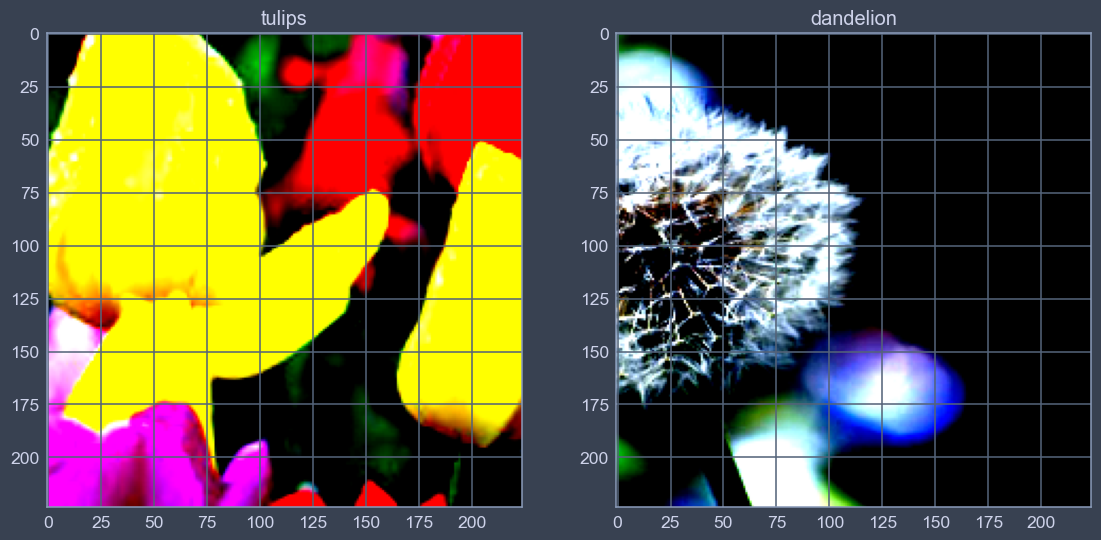

In [6]:
print(dt[0].shape)
check_img1 = dt[0].numpy()
check_img2 = dt[1].numpy()
print(type(dt[0]))
print(check_img1.transpose(1, 2, 0).shape)
ck1_idx = int(target[0].numpy())
ck2_idx = int(target[1].numpy())
if google_flowers:
    ck1_idx = str(target[0].numpy())
    ck2_idx = str(target[1].numpy())
print(ck2_idx)

# 显示图片
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
axes[0].imshow(check_img1.transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
axes[0].title.set_text(cls_2_name[ck1_idx])
axes[1].imshow(check_img2.transpose(1, 2, 0))
axes[1].title.set_text(cls_2_name[ck2_idx])
plt.show()

In [7]:
################################
# network
################################

class AlexNet(nn.Module):
    def __init__(self,num_classes=1000):
        super(AlexNet,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
            nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
            nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    def forward(self,x):
        x = self.feature_extraction(x)
        x = x.view(x.size(0),256*6*6)
        x = self.classifier(x)
        return x
    

In [8]:
alexnet = AlexNet(num_classes=num_classes)
alexnet

input = torch.randn(8,3,224,224)
out = alexnet(input)
print(out.shape)

torch.Size([8, 5])


In [9]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=50, device="cpu"):
    # print('---- Training ----')
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        # print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            #print(torch.max(F.softmax(output), dim=1)[1])
            #print(targets)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {},  Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [10]:
alexnet.to(device)

params = [p for p in alexnet.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

### Training model

In [ ]:
# Training model

train(alexnet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=30, device=device)

Epoch: 1,  Training Loss: 1.3931, Validation Loss: 1.2297, accuracy = 0.45
Epoch: 2,  Training Loss: 1.2118, Validation Loss: 1.2702, accuracy = 0.49
Epoch: 3,  Training Loss: 1.1217, Validation Loss: 0.9689, accuracy = 0.62
Epoch: 4,  Training Loss: 1.0336, Validation Loss: 0.9886, accuracy = 0.60
Epoch: 5,  Training Loss: 0.9590, Validation Loss: 0.8980, accuracy = 0.64
Epoch: 6,  Training Loss: 0.9411, Validation Loss: 0.9205, accuracy = 0.65
Epoch: 7,  Training Loss: 0.9046, Validation Loss: 0.8123, accuracy = 0.70
Epoch: 8,  Training Loss: 0.8833, Validation Loss: 0.7691, accuracy = 0.72
Epoch: 9,  Training Loss: 0.8403, Validation Loss: 0.8043, accuracy = 0.70
Epoch: 10,  Training Loss: 0.8015, Validation Loss: 0.7567, accuracy = 0.71
Epoch: 11,  Training Loss: 0.7964, Validation Loss: 0.7023, accuracy = 0.70
Epoch: 12,  Training Loss: 0.7760, Validation Loss: 0.7628, accuracy = 0.71
Epoch: 13,  Training Loss: 0.7403, Validation Loss: 0.6221, accuracy = 0.76
Epoch: 14,  Training 

### Test

In [ ]:
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=data_transform['val'])
n = 1 
labels = [x[n] for x in test_data]
print(labels)
print(np.unique(labels)) 

In [ ]:
batch_size=16
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                               shuffle=False, num_workers=nw)

loss_fn = torch.nn.CrossEntropyLoss()

alexnet.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

for batch in test_data_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = alexnet(inputs)
    targets = targets.to(device)
    loss = loss_fn(output,targets) 
    #test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_data_loader.dataset)

print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

In [ ]:
it = iter(test_data_loader)
it.__next__()
dt, labs = it.__next__()
dt = dt.to(device)
output = alexnet(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape((3, 1, 1)).to(device)
img_std = torch.tensor([0.229, 0.224, 0.225]).reshape((3, 1, 1)).to(device)
print(dt[0].cpu().numpy().shape)
print(img_mean.cpu().numpy().shape)

plt.figure(figsize=(16,15))
k = 0
for i in range(3):
    for j in range(4):
        ax = plt.subplot2grid((3,4), (i,j))
        img_dt = torch.mul(dt[k], img_std) + img_mean
        img_dt = img_dt*255
        img_dt = img_dt.to(torch.uint8)
        
        if torch.cuda.is_available():
            img_dt = img_dt.cpu().numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - false\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        else:
            img_dt = img_dt.numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - true\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()


In [ ]:
#dt = torch.randn(8,3,224,224).to(device)
img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape((3, 1, 1)).to(device)
img_std = torch.tensor([0.229, 0.224, 0.225]).reshape((3, 1, 1)).to(device)
print(img_mean.cpu().numpy().shape)
print(dt[0].cpu().numpy().shape)
img_dt = torch.mul(dt[0], img_std) + img_mean
img_dt = img_dt*255
img_dt = img_dt.to(torch.uint8)
print(img_dt)
img_dt = img_dt.cpu().numpy().transpose((1, 2, 0))
plt.figure()
plt.imshow(img_dt)
plt.show()